## Introduction

Over the past year we have seen the rise of generative AI that has mainly come in two forms:
1. Text-to-image generation powered by diffusion models like Stable Diffusion and DALL-E 2
2. Language models like ChatGPT and LLaMA

It turns out one of the key ingredients for the mainstream success of language models is the use of Reinforcement Learning from Human Feedback (RLHF) where language models are trained with human feedback to produce outputs that users are more likely to prefer. This has enabled these language models to more easily follow instructions, making these models significantly more accessible. Therefore the question arises if RLHF can be applied to diffusion models. This is a natural question to ask, since text-to-image diffusion models also struggle to follow prompts and tend to need prompt engineering skills in order to get desired results. A [paper in May 2023](https://arxiv.org/abs/2305.13301) by the Levine Lab at UC Berkeley explored how the RLHF paradigm can be applied to diffusion models. Their algorithm, cal Here we'll walk through a simple implementation of this paper. Let's get started!


First let's start with some basic imports:

In [2]:
import os
import requests
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import clip # pip install git+https://github.com/openai/CLIP.git
import torch
import random
import math
import wandb
from torch import nn
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image
from fastprogress import progress_bar, master_bar

Let's load our Stable Diffusion model. Let's also enable some performance optimizations (TF32 support, attention slicing, memory-efficient xformers attention) that will make it faster to work with our Stable Diffusion model for training.

In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cuda")
pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()
pipe.text_encoder.requires_grad_(False)
pipe.vae.requires_grad_(False)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


We're using the [diffusers](https://huggingface.co/docs/diffusers) library, which provides a simple-to-use interface for sampling the Stable Diffusion model using their pipeline:

In [4]:
prompt = "a photograph of an astronaut riding a horse"
img = pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

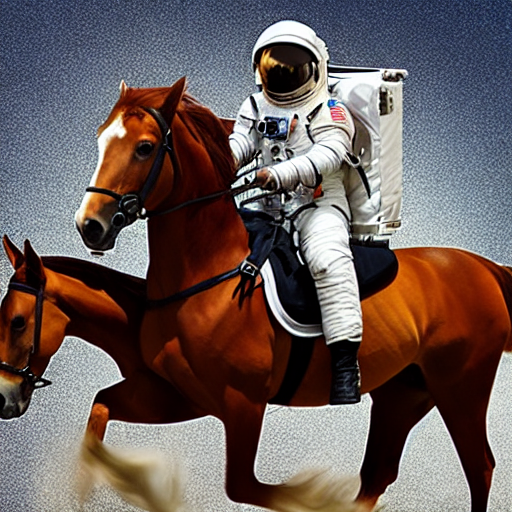

In [5]:
img

Okay then, we want to improve the images coming out of our model. In order to do so we should have some sort of score for the image that we can later optimize for. This score could represent how aesthetic the image is. This is frankly something that is quite subjective, and there is no mathematical equation for the aestheticness of an image. Instead we will use [LAION's aesthetic predictor](https://github.com/LAION-AI/aesthetic-predictor), which was trained on thousands of human aesthetic ratings of AI-generated images and is a linear model on top of CLIP features. Below is the standard inference code for the aesthetic predictor model:

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, xcol='emb', ycol='avg_rating'):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            #nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 16),
            #nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [7]:
def load_aesthetic_model_weights(cache="."):
    weights_fname = "sac+logos+ava1-l14-linearMSE.pth"
    loadpath = os.path.join(cache, weights_fname)

    if not os.path.exists(loadpath):
        url = (
            "https://github.com/christophschuhmann/"
            f"improved-aesthetic-predictor/blob/main/{weights_fname}?raw=true"
        )
        r = requests.get(url)

        with open(loadpath, "wb") as f:
            f.write(r.content)

    weights = torch.load(loadpath, map_location=torch.device("cpu"))
    return weights

In [8]:
def aesthetic_model_normalize(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

We need the CLIP model, whose features will be passed into our aesthetic predictor:

In [9]:
clip_model, preprocess = clip.load("ViT-L/14", device="cuda")

In [10]:
aesthetic_model = MLP(768)

In [11]:
aesthetic_model.load_state_dict(load_aesthetic_model_weights())
aesthetic_model.cuda()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [12]:
image = preprocess(img).unsqueeze(0).cuda()
with torch.no_grad(): image_features = clip_model.encode_image(image)

In [13]:
im_emb_arr = aesthetic_model_normalize(image_features.cpu().detach().numpy())
prediction = aesthetic_model(torch.from_numpy(im_emb_arr).float().cuda())

In [14]:
print(f'Aesthetic score: {prediction}')

Aesthetic score: tensor([[5.6835]], device='cuda:0', grad_fn=<AddmmBackward0>)


Just like, that, we get the aesthetic score given with this predictor. Let's paxkage this code into a function:

In [15]:
def aesthetic_scoring(img, preprocess, clip_model, aesthetic_model_normalize, aesthetic_model):
    image = preprocess(img).unsqueeze(0).cuda()
    with torch.no_grad(): image_features = clip_model.encode_image(image)
    im_emb_arr = aesthetic_model_normalize(image_features.cpu().detach().numpy())
    prediction = aesthetic_model(torch.from_numpy(im_emb_arr).float().cuda())
    return prediction

  0%|          | 0/50 [00:00<?, ?it/s]

Aesthetic score: 5.228103160858154


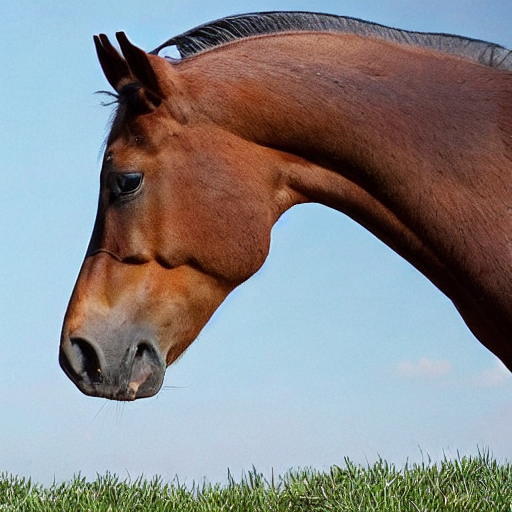

In [16]:
prompt = "a horse"
img = pipe(prompt).images[0]
print(f'Aesthetic score: {aesthetic_scoring(img, preprocess, clip_model, aesthetic_model_normalize, aesthetic_model)[0][0]}')
img

  0%|          | 0/50 [00:00<?, ?it/s]

Aesthetic score: 5.3236589431762695


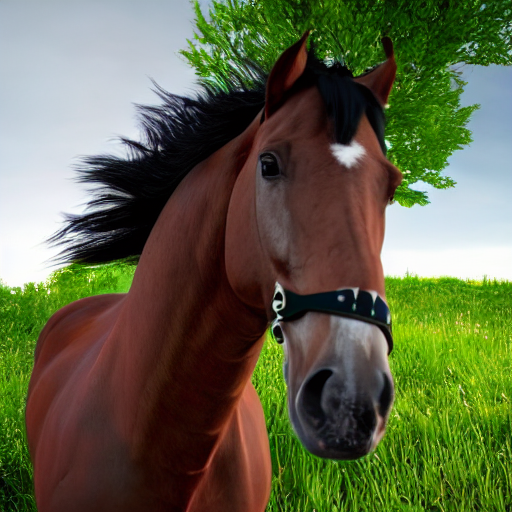

In [17]:
prompt = "a beautiful, exquisite portrait of a horse, 4k, unreal engine"
img = pipe(prompt).images[0]
print(f'Aesthetic score: {aesthetic_scoring(img, preprocess, clip_model, aesthetic_model_normalize, aesthetic_model)[0][0]}')
img

  0%|          | 0/50 [00:00<?, ?it/s]

Aesthetic score: 5.207968711853027


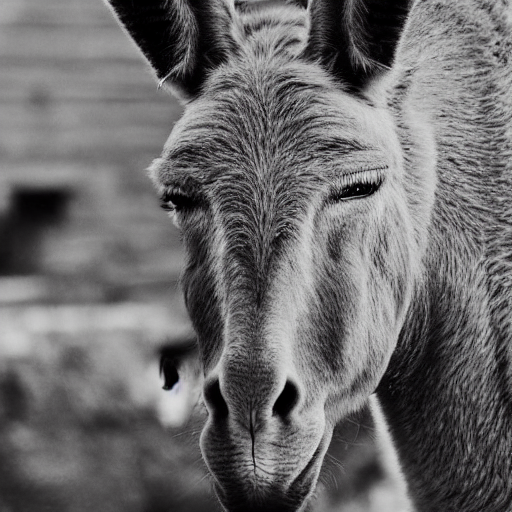

In [18]:
prompt = "a very ugly photograph of a donkey"
img = pipe(prompt).images[0]
print(f'Aesthetic score: {aesthetic_scoring(img, preprocess, clip_model, aesthetic_model_normalize, aesthetic_model)[0][0]}')
img

You can see if you prompt for something "ugly" we do get an image with a lower score. But the variation of the score doesn't tend to be much there seems to be a sort of average aesthetic score that most images fluctuate around (~5.3). Can we increase the average aesthetic score of the images produced by Stable Diffusion? That is what we will attempt to do using reinforcement learning (RL).

## What if we could optimize the aesthetic score?

Now that we have some sort of measure of quality of our image, our aesthetic score, we can optimize for it. In the RL literature, this measure of quality that we are optimizing for is referred to as the **reward**. The goal of RL algorithms is to optimize the reward. We will see how DDPO does this for diffusion models.

Before we go down the RL route though, it is worth examining if there are alternative approaches. Diffusion models, after all, are an extremely versatile framework, and people have been incorporating different constraints and forms of guidance during sampling in order to achieve desired results. Let's do a quick refresher about diffusion models and how guidance is applied.

### Diffusion model refresher

A diffusion model is described by a forward and reverse process. The forward process is when we start out with a clean image $\mathbf{x}_0$ and repeatedly add Gaussian noise $\epsilon_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ to give use noisier and noisier images $\mathbf{x}_t$. This is described by the following:

$$ q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t\mathbf{I}) $$

where $\beta_t$ is a predefined monotonically increasing variance schedule. The forward process runs for a total of $T$ timesteps and finally ends with pure noise $\mathbf{x}_T$. The reverse process starts with pure noise $\mathbf{x}_T$ and uses a neural network to repeatedly denoise the image giving us $\mathbf{x}_t$. The end of the reverse process gives us back our samples $\mathbf{x}_0$. This is described as follows:

$$ p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_t, t), \tilde{\beta}_t \mathbf{I}) $$

where $\tilde{\beta}_t$ is the variance schedule for the reverse schedule and $\mu_\theta(\mathbf{x}_t, t)$ is the denoising neural network. Note that the denoising neural network can be reparameterized to predict the noise $\epsilon_t$ in the image. So instead of predicting the denoised image $\hat{\mathbf{x}}_0$ directly, we can predict the noise in the image and subtract it out to get $\hat{\mathbf{x}}_0$. We train the reparameterized denoising neural network $\epsilon_\theta(\mathbf{x}_t, t)$ in the reverse diffusion process with a simple MSE loss:

$$ L_{simple} = \mathbb{E}_{t,\mathbf{x}_t, \epsilon_t} || \epsilon_t - \epsilon_\theta(\mathbf{x}_t, t) || $$

In practice, training and sampling is quite simple. During each training step, a random image $\mathbf{x}_0$ and timestep $t$ is selected, the forward process starts from $\mathbf{x}_0$ till timestep $t$ to get $\mathbf{x}_t$ using the noise $\epsilon_t$, this is passed into our denoising model, and the MSE between the $\epsilon_t$ used to calculate $\mathbf{x}_t$ and the predicted $\epsilon_\theta(\mathbf{x}_t, t)$ is optimized. During sampling, we start out with random Gaussian noise $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ and the denoising neural network is repeatedly applied to give us $\mathbf{x}_{t-1}$ until we reach our sample $\mathbf{x}_0$.

It is also worth noting the score matching intuition behind diffusion models. Specifically, $\epsilon_\theta(\mathbf(x)_t, t)$ turns out to actually be an estimate (up to a factor) of the "score function" $\nabla_\mathbf{x} \log p(\mathbf{x})$. Basically, what this means is that when we sample from a diffusion model, we are iteratively taking steps in the direction of this score function, which is this gradient of the likelihood. So the sampling is very much like an optimization problem. 

If any of this is unfamiliar to you, I recommend checking out the [fast.ai course](https://course.fast.ai/Lessons/part2.html) on the subject (I am somewhat biased though given I co-taught the class!).

Let's now discuss how additional constraints and guidance can be added during diffusion sampling. Basically, we want to model $p(\mathbf{x} | \mathbf{y})$ where $\mathbf{y}$ is some sort of condition or constraint (for example a class condition). In diffusion models, we could instead try to estimate $\nabla_\mathbf{x} \log p(\mathbf{x} | \mathbf{y})$ and use this in sampling. This can be expressed differently using Bayes' Rule:

$$ \begin{gathered}
p(\mathbf{x} \mid  \mathbf{y})=\frac{p( \mathbf{y} \mid \mathbf{x}) \cdot p(\mathbf{x})}{p( \mathbf{y})} \\
\Longrightarrow \log p(\mathbf{x} \mid  \mathbf{y})=\log p( \mathbf{y} \mid \mathbf{x})+\log p(\mathbf{x})-\log p( \mathbf{y}) \\
\Longrightarrow \nabla_\mathbf{x} \log p(\mathbf{x} \mid  \mathbf{y})=\nabla_\mathbf{x} \log p( \mathbf{y} \mid \mathbf{x})+\nabla_\mathbf{x} \log p(\mathbf{x})
\end{gathered} $$

The second term is our score function that is already being estimated by our diffusion model $\epsilon_\theta(\mathbf{x}_t, t)$. The first term, however, is the gradient of the log likelihood of a classifier $p(\mathbf{x} \mid  \mathbf{y})$ with respect to $\mathbf{x}$. What this means is that during diffusion model sampling, if we use a modified $\hat{\epsilon}_\theta(\mathbf{x}_t,t)$ with the classifier gradient added to it, we can get samples that adhere to the desired condition. 

More broadly, losses can be applied to the noisy images and its gradient can be added to the score function/denoising network output to try to obtain images that better adhere to some desired constraints. This is the idea behind CLIP-guided diffusion, for example, where the similarity between the CLIP text embedding of a prompt and the CLIP image embedding of the images during sampling are maximized.

Can we use guidance to get diffusion models to generate more aesthetic images that better adhere to user prompts? Potentially yes, but there are many challenges that may make it undesirable. 

Strictly speaking, the proper way to perform classifier guidance is to use a classifier trained on either the noisy images $\mathbf{x}_t$ or the predicted denoised images $\hat{\mathbf{x}}_0$ (which tend to be blurry, especially early on in sampling), which is what the original classifier guidance paper demonstrates. Note, it is possible to use classifiers and other models trained on regular images and get reasonable results for guidance, even though noisy or blurry images will likely be out-of-distribution. For example CLIP isn't trained on noisy images but is used in CLIP-guided diffusion. But often to get reasonable results, various hacks and tricks are required (in the case of CLIP-guided diffusion, the use of this technique fell out of popularity once diffusion models properly conditioned on CLIP features like Stable Diffusion were developed, and CLIP guidance applied on top of models like Stable Diffusion often showed minimal benefit).

Additionally, note that guidance requires the calculation of whatever guidance loss we have and autograd of that loss at each step in the sampling process. This can add a significant overhead to the sampling time compared to guidance-free sampling. The situation is made worse with latent diffusion models like Stable Diffusion, where the latents often need to be decoded to full images in order to apply the classifier/loss, resulting in additional computational overhead. 

For these reasons, we will instead apply reinforcement learning to obtain a diffusion model after optimizing arbitrary constraints (the reward function), such as aesthetic scores. As we will see, the generated images from the starting diffusion model are passed into the reward function, so there is no concern of images being out-of-distribution. Additionally, we will obtain a diffusion model that provides higher scoring images directly, not through sampling changes like guidance.


Okay let's proceed with trying to apply RL to diffusion models. First we'll create a dataset generator - Stable Diffusion generated images given some prompts. We'll use animal prompts:

In [19]:
!wget https://raw.githubusercontent.com/formigone/tf-imagenet/master/LOC_synset_mapping.txt

--2023-06-13 09:54:06--  https://raw.githubusercontent.com/formigone/tf-imagenet/master/LOC_synset_mapping.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31675 (31K) [text/plain]
Saving to: ‘LOC_synset_mapping.txt.14’

LOC_synset_mapping. 100%[===================>]  30.93K  --.-KB/s    in 0.006s  

2023-06-13 09:54:06 (5.24 MB/s) - ‘LOC_synset_mapping.txt.14’ saved [31675/31675]



In [20]:
synsets = {k:v for k,v in [o.split(',')[0].split(' ', maxsplit=1) for o in Path('LOC_synset_mapping.txt').read_text().splitlines()]}

imagenet_classes = list(synsets.values())

In [21]:
def imagenet_animal_prompts():
    animal = random.choice(imagenet_classes[:397])
    prompts = f'{animal}'
    return prompts

In [22]:
imagenet_animal_prompts()

'sea urchin'

Put into a dataset class:

In [23]:
class PromptDataset(torch.utils.data.Dataset):
    def __init__(self, prompt_fn, num):
        super().__init__()
        self.prompt_fn = prompt_fn
        self.num = num
        
    def __len__(self): return self.num
    def __getitem__(self, x): return self.prompt_fn()

Next let's set up our sampling loop. For simplicity, we'll just use the DDIM scheduler:

In [24]:
pipe.scheduler = DDIMScheduler(
    num_train_timesteps=pipe.scheduler.num_train_timesteps,
    beta_start=pipe.scheduler.beta_start,
    beta_end=pipe.scheduler.beta_end,
    beta_schedule=pipe.scheduler.beta_schedule,
    trained_betas=pipe.scheduler.trained_betas,
    clip_sample=pipe.scheduler.clip_sample,
    set_alpha_to_one=pipe.scheduler.set_alpha_to_one,
    steps_offset=pipe.scheduler.steps_offset,
    prediction_type=pipe.scheduler.prediction_type
)

Below we have a sampling function, that also gives us intermediate timesteps. Again this is a pretty standard diffusion sampling loop, check out [HuggingFace blog post](https://huggingface.co/blog/stable_diffusion) for more information.

In [25]:
@torch.no_grad()
def sd_sample(prompts, pipe, height, width, guidance_scale, num_inference_steps, eta, device):
    scheduler = pipe.scheduler
    unet = pipe.unet
    text_embeddings = pipe._encode_prompt(prompts,device, 1, do_classifier_free_guidance=guidance_scale > 1.0)

    scheduler.set_timesteps(num_inference_steps, device=device)
    latents = torch.randn((len(prompts), unet.in_channels, height//8, width//8)).to(device)

    all_step_preds = []

    for i, t in enumerate(progress_bar(scheduler.timesteps)):
        input = torch.cat([latents] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

        # compute the "previous" noisy sample
        scheduler_output = scheduler.step(pred, t, latents, eta)

        all_step_preds.append(scheduler_output)
        latents = scheduler_output.prev_sample
    
    return latents, all_step_preds

In [26]:
preds, all_step_preds = sd_sample([prompt]*2, pipe, 512, 512, 7.5, 50, 1, 'cuda')

The sampling function only gives us latents, and they need to be decoded by a VAE to get the final images:

In [27]:
@torch.no_grad()
def decoding_fn(latents,pipe):
    images = pipe.vae.decode(1 / 0.18215 * latents.cuda()).sample
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (images * 255).round().astype("uint8")
    return images

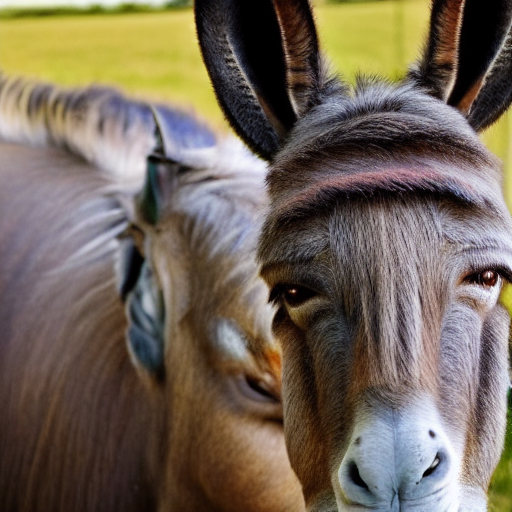

In [28]:
Image.fromarray(decoding_fn(preds,pipe)[0])

Let's again calculate the aesthetic score. We have to make a slight modification to our `aesthetic_scoring` function so it can handle batches.

In [29]:
def aesthetic_scoring(imgs, preprocess, clip_model, aesthetic_model_normalize, aesthetic_model):    
    imgs = torch.stack([preprocess(Image.fromarray(img)).cuda() for img in imgs])
    with torch.no_grad(): image_features = clip_model.encode_image(imgs)
    im_emb_arr = aesthetic_model_normalize(image_features.cpu().detach().numpy())
    prediction = aesthetic_model(torch.from_numpy(im_emb_arr).float().cuda())
    return prediction

In [30]:
imgs = decoding_fn(preds,pipe)
aesthetic_scoring(imgs, preprocess, clip_model, aesthetic_model_normalize, aesthetic_model)

tensor([[5.1635],
        [5.4475]], device='cuda:0', grad_fn=<AddmmBackward0>)

Now we can initialize our dataset generator, which provides prompts that we sample with, generate images, and pass into the aesthetic predictor in just a few lines of code:

In [31]:
train_set = PromptDataset(imagenet_animal_prompts, 1000)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True, num_workers=0)

In [32]:
prompts = next(iter(train_dl))
preds, all_step_preds = sd_sample(prompts, pipe, 512, 512, 7.5, 50, 1, 'cuda')
imgs = decoding_fn(preds,pipe)
rewards = aesthetic_scoring(imgs, preprocess, clip_model, aesthetic_model_normalize, aesthetic_model)

polecat


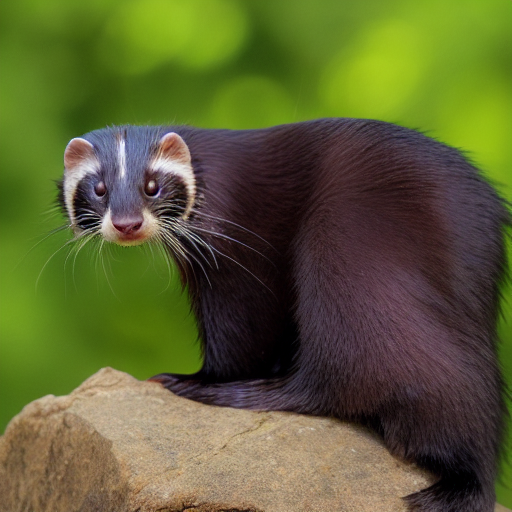

In [33]:
index = torch.where(rewards == rewards.min())[0][0]
print(prompts[index])
Image.fromarray(imgs[index])

garter snake


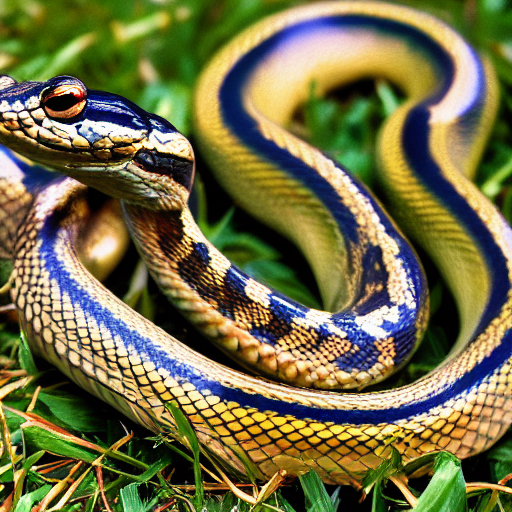

In [34]:
index = torch.where(rewards == rewards.max())[0][0]
print(prompts[index])
Image.fromarray(imgs[index])

Once again, the aesthetic predictor provides _rewards_ and these are used in optimization with RL. Our goal is to maximize the reward! 

For stability during RL training, the rewards are usually normalized. There are different ways of doing this, but the DDPO paper utilizes a simple approach, which is to normalize based on unique prompts. Basically, a queue is set up with prompts and the corresponding rewards, which some given buffer size. When a new (prompt, reward) pair is obtained, it is added to the queue. If the queue for that unique prompt is not long enough, the reward is just normalized over the whole batch. Else, it is normalized based on the statistics for that specific prompt. This is implemented below:

In [35]:
from collections import deque
class PerPromptStatTracker:
    def __init__(self, buffer_size, min_count):
        self.buffer_size = buffer_size
        self.min_count = min_count
        self.stats = {}

    def update(self, prompts, rewards):
        unique = np.unique(prompts)
        advantages = np.empty_like(rewards)
        for prompt in unique:
            prompt_rewards = rewards[prompts == prompt]
            if prompt not in self.stats:
                self.stats[prompt] = deque(maxlen=self.buffer_size)
            self.stats[prompt].extend(prompt_rewards)

            if len(self.stats[prompt]) < self.min_count:
                mean = np.mean(rewards)
                std = np.std(rewards) + 1e-6
            else:
                mean = np.mean(self.stats[prompt])
                std = np.std(self.stats[prompt]) + 1e-6
            advantages[prompts == prompt] = (prompt_rewards - mean) / std

        return advantages

In [36]:
per_prompt_stat_tracker = PerPromptStatTracker(buffer_size=32, min_count=16)

In [37]:
rewards.squeeze().cpu()

tensor([5.4786, 5.5764], grad_fn=<ToCopyBackward0>)

In [38]:
advantages = per_prompt_stat_tracker.update(np.array(prompts), rewards.squeeze().cpu().detach().numpy())

In [39]:
advantages

array([-0.99998444,  0.9999747 ], dtype=float32)

In [40]:
per_prompt_stat_tracker.stats

{'garter snake': deque([5.576433], maxlen=32),
 'polecat': deque([5.478563], maxlen=32)}

We have the reward normalization set up. Let's look at some of the intermediate timesteps:

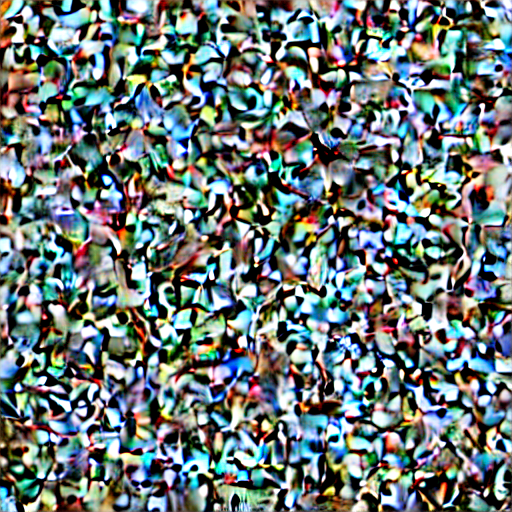

In [41]:
Image.fromarray(decoding_fn(all_step_preds[0].prev_sample, pipe)[0])

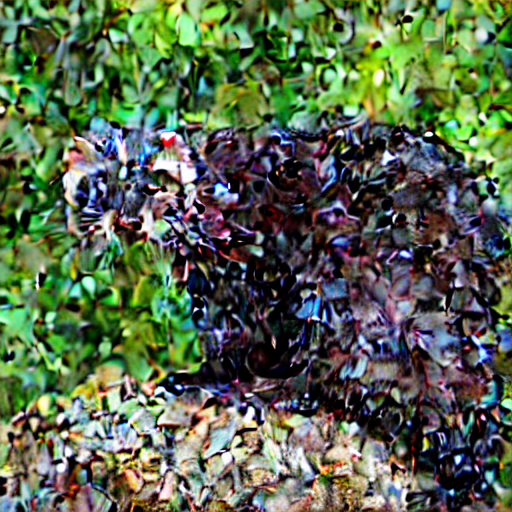

In [42]:
Image.fromarray(decoding_fn(all_step_preds[30].prev_sample, pipe)[0])

As expected, we get pure noise (in the latent space, it looks somewhat different when decoded by the Stable Diffusion VAE) at the beginning of sampling, and as sampling progresses, the images starts to take shape.

## The DDPO algorithm

Okay let's now dig into how reinforcement learning works and derive the DDPO objective. A reminder that what we want to do is to maximize the reward signal. We can mathematically express this as follows:

$$ \theta^\star = \arg \max_\theta \mathbb{E}_{\mathbf{x}_0 \sim p_\theta(\cdot \mid \mathbf{c})} [r(\mathbf{x}_0 \mid \mathbf{c})] $$

where $\theta$ is the weights of our diffusion model, $\mathbf{c}$ is some conditioning for the diffusion model, and $r(\cdot)$ is our reward function.

It would be nice to directly maximize for $r(\cdot)$ and if our model was a single evaluation of a neural network, we could simply backpropagate through the neural network and use an optimizer to update the weights. But that's not what happens with a diffusion model! We have multiple timesteps for which we apply our denoising neural network. This constructs a **trajectory** as its known in the RL literature. In standard RL literature, our trajectory is composed of **states** and **actions**. A model that we are optimizing provides the next action given the current state, and this model is referred to as the **policy**. This framework is known as a **Markov Decision Process (MDP)**. Note that in the general MDP framework, a reward is usually given after each action, and we optimize over the sum of rewards over the whole trajectory.

We can easily describe diffusion models as an MDP, which will allow us to use standard results in RL for diffusion model optimization.

$$ \begin{array}{rrr}
\mathbf{s}_t \triangleq\left(\mathbf{c}, t, \mathbf{x}_t\right) & \pi\left(\mathbf{a}_t \mid \mathbf{s}_t\right) \triangleq p^{\text{diffusion}}_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{c}\right) & p\left(\mathbf{s}_{t+1} \mid \mathbf{s}_t, \mathbf{a}_t\right) \triangleq\left(\delta_{\mathbf{c}}, \delta_{t-1}, \delta_{\mathbf{x}_{t-1}}\right) \\
\mathbf{a}_t \triangleq \mathbf{x}_{t-1} & \rho_0\left(\mathbf{s}_0\right) \triangleq\left(p(\mathbf{c}), \delta_T, \mathcal{N}(\mathbf{0}, \mathbf{I})\right) & R\left(\mathbf{s}_t, \mathbf{a}_t\right) \triangleq \begin{cases}r\left(\mathbf{x}_0, \mathbf{c}\right) & \text { if } t=0 \\
0 & \text { otherwise }\end{cases}
\end{array} $$

$$ \mathcal{J}(\theta)=\mathbb{E}_{\tau \sim p(\cdot \mid \pi)}\left[\sum_{t=0}^T R\left(\mathbf{s}_t, \mathbf{a}_t\right)\right] = \mathbb{E}_{\mathbf{x}_0 \sim p_\theta(\cdot \mid \mathbf{c})} \left[r(\mathbf{x}_0 \mid \mathbf{c})\right] $$

$\mathbf{s}_t$ is the state, which is just the current noisy image $\mathbf{x}_t$ (along with the timestep and condition info). $\mathbf{a}_t$ is the action, which is the slightly less noisy image $\mathbf{x}_{t-1}$. $\pi\left(\mathbf{a}_t \mid \mathbf{s}_t\right)$ is the policy that takes the current state and provides the next action, which is our diffusion model $p^{\text{diffusion}}_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{c}\right)$. $\rho_0\left(\mathbf{s}_0\right)$ is the distribution of the initial states, which in this case is the same distribution for $\mathbf{x}_T$, a standard isotropic normal distribution, with the timestep always being $T$ and the conditioning having whatever prior distribution as in the dataset. $p\left(\mathbf{s}_{t+1} \mid \mathbf{s}_t, \mathbf{a}_t\right)$ is giving $\mathbf{s}_{t+1}$ given the current state and action, and is basically just saying it always goes to the state associated with $\mathbf{x}_{t-1}$. $R\left(\mathbf{s}_t, \mathbf{a}_t\right)$ is the reward after each action/state (which is zero until the very last step when the generation is complete).The entire trajectory can be represented as $\tau$ and the probability density for trajectories as $p_\theta(\mathbf{s}_0, \mathbf{a}_0, \cdot \cdot \cdot, \mathbf{s}_T, \mathbf{a}_T) = p_\theta(\tau)$ Note this $p_\theta$ is different from the diffusion model $p_\theta$ as it is a function of $\tau$, a bit confusing! So going forward the diffusion model is referred to as $p^\text{diffusion}_\theta$.

![](image.png)

Okay, with this framework in place it becomes trivial to apply standard **policy gradient** optimization methods like **REINFORCE** and **proximal policy optimization (PPO)**. Let's go over these two algorithms now. I have also written a more principled from-scratch derivation over [here] 

We'll start by looking at the general case of taking the gradient of the expectation over $p_\theta(\mathbf{x})$ of some function $f(\mathbf{x})$.

$$
\begin{align} 
\nabla_\theta \mathbb{E}_{p_{\theta}}[f(\mathbf{x})] 
&= \nabla_\theta \int p_{\theta}(\mathbf{x}) f(\mathbf{x}) d\mathbf{x} \\
&= \int \nabla_\theta p_{\theta}(\mathbf{x}) f(\mathbf{x}) d\mathbf{x} \\
&= \int \frac{p_{\theta}(\mathbf{x})}{p_{\theta}(\mathbf{x})} \nabla_\theta p_{\theta}(\mathbf{x}) f(\mathbf{x}) d\mathbf{x} \\
&= \int p_{\theta}(\mathbf{x}) \frac{\nabla_\theta p_{\theta}(\mathbf{x})}{p_{\theta}(\mathbf{x})} f(\mathbf{x}) d\mathbf{x} \\
&= \int p_{\theta}(\mathbf{x}) \nabla_\theta \log p_{\theta}(\mathbf{x}) f(\mathbf{x}) d\mathbf{x} \\
&= \mathbb{E}_{p_{\theta}} \big[ \nabla_\theta \log p_{\theta}(\mathbf{x})f(\mathbf{x}) \big]
\end{align}
$$

This is referred to as the _score function gradient estimator_. 

Let's think more about what this is doing. We want to calculate the gradient of $\mathbb{E}_{p_{\theta}}[f(\mathbf{x})]$ with respect to $\theta$. That is, we want to know how we can change $\theta$ such that we get samples from $p_\theta(\mathbf{x}$ that on average give higher $f(\mathbf{x})$ values. What this estimator says is that we can take the gradient $\nabla_\theta \log p_{\theta}(\mathbf{x})$ (which tells you how to change $\theta$ to increase the likelihood of $\mathbf{x}$ under your distribtuion $p_\theta(\mathbf{x})$), and weight it with $f(\mathbf{x})$. So if this is being used in gradient ascent for example, we are placing more weight on updates that make high-scoring $\mathbf{x}$ samples more likely under our model $p_\theta(\mathbf{x})$.

When we apply this to the MDP framework and simplify, we can get our **policy gradient**:

$$ \nabla_\theta \mathcal{J}(\theta) = \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[\left(\sum^T_{t=0} \nabla_\theta \log \pi_\theta\left(\mathbf{a}_t \mid \mathbf{s}_t\right) \right) \left(\sum^T_{t=0}R(\mathbf{s}_t, \mathbf{a}_t) \right) \right] $$

This gradient is referred to as the **REINFORCE** gradient and is only one type of policy gradient that could be used. Of course, this policy gradient is then used to update the weights of our model using gradient ascent:

$$ \theta \leftarrow \theta + \alpha \nabla_\theta \mathcal{J}(\theta) $$

where $\alpha$ is some learning rate.

One implementation point is that the expectation is over the trajectories but of course we can't take and sum over all possible trajectories. The expectation is estimated with just the sampled trajectories in the currenty batch. One other implementation point to mention: we could calculate our gradient and then pass that gradient to our optimizer, or we could let autograd handle the calculation of the gradient by constructing a loss function and treating it as a standard training loop. The latter is what is done in practice even though it is not explicitly mentioned often in the papers. So our loss function is:

$$ \mathcal{L}(\theta) = \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[ - \left(\sum^T_{t=0} \log \pi_\theta\left(\mathbf{a}_t \mid \mathbf{s}_t\right) \right) \left(\sum^T_{t=0}R(\mathbf{s}_t, \mathbf{a}_t) \right) \right] $$

Again, let's reinforce the intuition behind REINFORCE gradient/loss function (pun definitely intended). You can see the loss looks very much like a negative log-likelihood loss, with the actions as our target. The diference here is that it is weighted by the reward. What this loss is doing is trying to make high-reward trajectories more likely and low-reward trajectories less likely.

![](<1 zkOBQ9Izq28yXCANTmdKtA.webp>)

Okay so we can simply plug in our diffusion model terms based on how it fits into the MDP framework, which we described earlier. We get:

$$ \nabla_\theta \mathcal{J}(\theta) = \mathbb{E} \left[\left(\sum^T_{t=0} \nabla_\theta \log p^\text{diffusion}_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{c}, t, \mathbf{x}_t\right) \right) r(\mathbf{x}_0, \mathbf{c}) \right] $$

This objective and gradient estimator is referred in the paper as **DDPO<sub>SF</sub>**.

One challenge with this approach is that for each optimization step, the sampling from the current iteration of the model needs to be performed, we need to re-calculate $\mathbf{x}_t$ as it comes from the current version of the model. This can be computationally expensive and wasteful, as the samples collected with previous iterations of the model cannot be used to learn. 

One trick to address this is known as importance sampling. This relies on the following identity (trivial to demonstrate based on the expectation definition):

$$ \mathbb{E}_{x\sim p(x)} \left[f(x)\right] = \mathbb{E}_{x\sim q(x)} \left[\frac{p(x)}{q(x)}f(x)\right] $$

Applying importance sampling gives us the following:

$$ \nabla_\theta \mathcal{J}(\theta) = \mathbb{E}_{\tau \sim p_{\theta_{old}} \left(\tau \right)} \left[\left(\sum^T_{t=0} \frac{\pi_\theta\left(\mathbf{a}_t \mid \mathbf{s}_t\right)}{\pi_{\theta_{old}}\left(\mathbf{a}_t \mid \mathbf{s}_t\right)} \nabla_\theta \log \pi_\theta\left(\mathbf{a}_t \mid \mathbf{s}_t\right) \right) \left(\sum^T_{t=0}R(\mathbf{s}_t, \mathbf{a}_t) \right) \right] $$

Again this can be written down as a loss function that we perform gradient descent on (sometimes referred to as the **surrogate loss**):

$$ \mathcal{L}(\theta) = \mathbb{E}_{\tau \sim p_{\theta_{old}} \left(\tau \right)} \left[-\left(\sum^T_{t=0} \frac{\pi_\theta\left(\mathbf{a}_t \mid \mathbf{s}_t\right)}{\pi_{\theta_{old}}\left(\mathbf{a}_t \mid \mathbf{s}_t\right)} \right) \left(\sum^T_{t=0}R(\mathbf{s}_t, \mathbf{a}_t) \right) \right] $$

Again, we can plug in the diffusion model terms based on the MDP framework and get this loss function:

$$ L(\theta) = \mathbb{E} \left[ - \sum^T_{t=0} \frac{p^\text{diffusion}_\theta(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t)}{p^\text{diffusion}_{\theta_{old}}(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t)} r(\mathbf{x}_0,\mathbf{c}) \right] $$

Minimization of this loss function is equivalent to gradient with the following gradient:

$$ \hat g = \mathbb{E} \left[\sum^T_{t=0} \frac{p^\text{diffusion}_\theta(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t)}{p^\text{diffusion}_{\theta_{old}}(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t)} \nabla_\theta p^\text{diffusion}_\theta(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t) r(\mathbf{x}_0,\mathbf{c}) \right] $$

Note that the reward $r(\mathbf{x}_0,\mathbf{c})$ is usually normalized, and the normalized reward is referred to the advantage $A(\mathbf{x}_0,\mathbf{c})$. So the advantage can be negative if it's less than average. 

Note that we don't want current policy diverge too much from the previous policy, otherwise we may diverge and get a bad policy. To help address this, we can apply clipping to the importance sampling ratio to the loss function:

$$ L(\theta) = \mathbb{E} \left[ - \sum^T_{t=0} \min \left(\frac{p^\text{diffusion}_\theta(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t)}{p^\text{diffusion}_{\theta_{old}}(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t)} A(\mathbf{x}_0,\mathbf{c}), \mathrm{clip} \left( \frac{p^\text{diffusion}_\theta(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t)}{p^\text{diffusion}_{\theta_{old}}(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t)}, 1-\epsilon, 1+\epsilon  \right) A(\mathbf{x}_0,\mathbf{c}) \right) \right] $$

So if the policy diverges too much (the ratio is either much larger or much smaller than 1) the loss function is clipped to a certain value and the gradient will be zero and no updates will be made. The below diagram (taken from [here](https://stackoverflow.com/questions/46422845/what-is-the-way-to-understand-proximal-policy-optimization-algorithm-in-rl)) clarifies this further:

![](https://i.stack.imgur.com/gasbI.png)

Note that DDPO also clips the advantages themselves $\mathrm{clip} A(\mathbf{x}_0,\mathbf{c}) $ in its implementation but this is not described in the paper, so I have not included it in the loss function.

The loss function can be written in a way that's numerically easier to calculate/more stable (using logs, ignoring the clipping for now):

$$ L(\theta) = \mathbb{E} \left[ - \sum^T_{t=0} \exp{\left(\log p^\text{diffusion}_\theta(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t) -\log p^\text{diffusion}_{\theta_{old}}(\mathbf{x}_{t-1} | \mathbf{c},t,\mathbf{x}_t) \right)} A(\mathbf{x}_0,\mathbf{c}) \right] $$

The objective and gradient estimator described here is referred in the paper as **DDPO<sub>IS</sub>**. It is pretty much the same as **proximal policy optimization (PPO)**, applied to diffusion models.

For a more complete derivation of the DDPO objective from scratch, see [here](ddpo_derivation.pdf).

In order to start implementing this loss function, let's calculate the log probs, which is easy for a normal distribution:

In [43]:
def calculate_log_probs(prev_sample, prev_sample_mean, std_dev_t):
    std_dev_t = torch.clip(std_dev_t, 1e-6)
    log_probs = -((prev_sample.detach() - prev_sample_mean) ** 2) / (2 * std_dev_t ** 2) - torch.log(std_dev_t) - math.log(math.sqrt(2 * math.pi))
    return log_probs

We need to get those log probs of the original model so our sampling function should return that. Let's update our sampling function to do that:

In [44]:
@torch.no_grad()
def sd_sample(prompts, pipe, height, width, guidance_scale, num_inference_steps, eta, device):
    scheduler = pipe.scheduler
    unet = pipe.unet
    text_embeddings = pipe._encode_prompt(prompts,device, 1, do_classifier_free_guidance=guidance_scale > 1.0)

    scheduler.set_timesteps(num_inference_steps, device=device)
    latents = torch.randn((len(prompts), unet.in_channels, height//8, width//8)).to(device)

    all_step_preds, log_probs = [latents], []


    for i, t in enumerate(progress_bar(scheduler.timesteps)):
        input = torch.cat([latents] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

        # compute the "previous" noisy sample mean and variance, and get log probs
        scheduler_output = scheduler.step(pred, t, latents, eta, variance_noise=0)
        t_1 = t - scheduler.config.num_train_timesteps // num_inference_steps
        variance = scheduler._get_variance(t, t_1)
        std_dev_t = eta * variance ** (0.5)
        prev_sample_mean = scheduler_output.prev_sample # this is the mean and not full sample since variance is 0
        prev_sample = prev_sample_mean + torch.randn_like(prev_sample_mean) * std_dev_t # get full sample by adding noise
        log_probs.append(calculate_log_probs(prev_sample, prev_sample_mean, std_dev_t).mean(dim=tuple(range(1, prev_sample_mean.ndim))))

        all_step_preds.append(prev_sample)
        latents = prev_sample
    
    return latents, torch.stack(all_step_preds), torch.stack(log_probs)

We can get everything we need for the loss function now (intermediate timesteps, log_probs, rewards):

In [45]:
per_prompt_stat_tracker = PerPromptStatTracker(buffer_size=32, min_count=16)
prompts = next(iter(train_dl))
pipe.text_encoder.to('cuda')
pipe.vae.to('cuda')
preds, all_step_preds, log_probs = sd_sample(prompts, pipe, 512, 512, 7.5, 50, 1, 'cuda')
imgs = decoding_fn(preds,pipe)
rewards = aesthetic_scoring(imgs, preprocess, clip_model, aesthetic_model_normalize, aesthetic_model)
advantages = torch.from_numpy(per_prompt_stat_tracker.update(np.array(prompts), rewards.squeeze().cpu().detach().numpy())).float().to('cuda')

Here's a function to compute the loss function:

In [ ]:
def compute_loss(x_t, original_log_probs, advantages, clip_advantages, clip_ratio, prompts, pipe, num_inference_steps, guidance_scale, eta, device):
    scheduler = pipe.scheduler
    unet = pipe.unet
    text_embeddings = pipe._encode_prompt(prompts,device, 1, do_classifier_free_guidance=guidance_scale > 1.0).detach()
    scheduler.set_timesteps(num_inference_steps, device=device)
    loss_value = 0.
    for i, t in enumerate(progress_bar(scheduler.timesteps)):
        clipped_advantages = torch.clip(advantages, -clip_advantages, clip_advantages).detach()
        
        input = torch.cat([x_t[i].detach()] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

        # compute the "previous" noisy sample mean and variance, and get log probs
        scheduler_output = scheduler.step(pred, t, x_t[i].detach(), eta, variance_noise=0)
        t_1 = t - scheduler.config.num_train_timesteps // num_inference_steps
        variance = scheduler._get_variance(t, t_1)
        std_dev_t = eta * variance ** (0.5)
        prev_sample_mean = scheduler_output.prev_sample
        current_log_probs = calculate_log_probs(x_t[i+1].detach(), prev_sample_mean, std_dev_t).mean(dim=tuple(range(1, prev_sample_mean.ndim)))

        # calculate loss

        ratio = torch.exp(current_log_probs - original_log_probs[i].detach()) # this is the importance ratio of the new policy to the old policy
        unclipped_loss = -clipped_advantages * ratio # this is the surrogate loss
        clipped_loss = -clipped_advantages * torch.clip(ratio, 1. - clip_ratio, 1. + clip_ratio) # this is the surrogate loss, but with artificially clipped ratios
        loss = torch.max(unclipped_loss, clipped_loss).mean() # we take the max of the clipped and unclipped surrogate losses, and take the mean over the batch
        loss.backward() # perform backward here, gets accumulated for all the timesteps

        loss_value += loss.item()
    return loss_value

In [47]:
loss = compute_loss(all_step_preds, log_probs, advantages, 10, 1e-4, prompts, pipe, 50, 7.5, 1, 'cuda')
print(loss)

2.6168066263198853


## Complete training loop

Now that we can calculate the loss function, we can construct the full training loop. For a single epoch we:
1. Sample from the diffusion model `num_samples_per_epoch`times, collecting the intermediate noisy images and log probs.
2. Pass the samples to the reward model and get reward, which we normalize to get advantage.
3. For `num_inner_epochs` times, we go over each sample compute the loss, backpropagate, and update our diffusion model.


Let's define all our hyperparameters. We will be training Stable Diffusion v1.4 on ImageNet animal prompts as defined earlier, using the LAION Aesthetic classifier as our reward model.

Note that if we set `num_inner_epochs` to a high amount, this would be very data-efficient since we would be repeatedly using the previously generated trajectories, but we would probably significantly diverge from the original policy that we used to get those trajectories (or it would at least get clipped frequently in the loss). So we set `num_inner_epochs=1`. This is still pretty efficient using DDPO<sub>IS</sub> because otherwise with DDPO<sub>SF</sub> you'd need to resample after every iteration (when model is updated) instead of after `num_samples_per_epoch=128` that we have here.

In [ ]:
num_samples_per_epoch = 128
num_epochs = 50
num_inner_epochs = 1
num_timesteps = 50
batch_size = 4
img_size = 512
lr = 5e-6
clip_advantages = 10.0
clip_ratio = 1e-4
cfg = 5.0

Okay let's set everything up:

In [ ]:
# group all reward function stuff
def reward_fn(imgs, device):
    clip_model.to(device)
    aesthetic_model.to(device)
    rewards = aesthetic_scoring(imgs, preprocess, clip_model, aesthetic_model_normalize, aesthetic_model)
    clip_model.to('cpu')
    aesthetic_model.to('cpu')
    return rewards

In [ ]:
# a function to sample from the model and calculate rewards
def sample_and_calculate_rewards(prompts, pipe, image_size, cfg, num_timesteps, decoding_fn, reward_fn, device):
    preds, all_step_preds, log_probs = sd_sample(prompts, pipe, image_size, image_size, cfg, num_timesteps, 1, device)
    imgs = decoding_fn(preds,pipe)    
    rewards = reward_fn(imgs, device)
    return imgs, rewards, all_step_preds, log_probs

Here we create our dataset, which is just randomly chosen prompts:

In [ ]:
train_set = PromptDataset(imagenet_animal_prompts, num_samples_per_epoch)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
per_prompt_stat_tracker = PerPromptStatTracker(buffer_size=32, min_count=16)
sample_prompts = next(iter(train_dl)) # sample a batch of prompts to use for visualization

In [ ]:
pipe.unet.enable_gradient_checkpointing() # more performance optimization

In [ ]:
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=lr, weight_decay=1e-4) # optimizer

Now that we are set up, let's start training! You can see the training loop is quite simple!

In [ ]:
for epoch in master_bar(range(num_epochs)):
    all_step_preds, log_probs, advantages, all_prompts, all_rewards = [], [], [], [], []

    # sampling `num_samples_per_epoch` images and calculating rewards
    for i, prompts in enumerate(progress_bar(train_dl)):
        batch_imgs, rewards, batch_all_step_preds, batch_log_probs = sample_and_calculate_rewards(prompts, pipe, img_size, cfg, num_timesteps, decoding_fn, reward_fn, 'cuda')
        batch_advantages = torch.from_numpy(per_prompt_stat_tracker.update(np.array(prompts), rewards.squeeze().cpu().detach().numpy())).float().to('cuda')
        all_step_preds.append(batch_all_step_preds)
        log_probs.append(batch_log_probs)
        advantages.append(batch_advantages)
        all_prompts += prompts
        all_rewards.append(rewards)
    
    all_step_preds = torch.cat(all_step_preds, dim=1)
    log_probs = torch.cat(log_probs, dim=1)
    advantages = torch.cat(advantages)
    all_rewards = torch.cat(all_rewards)

    # inner loop
    for inner_epoch in progress_bar(range(num_inner_epochs)):
        # chunk them into batches
        all_step_preds_chunked = torch.chunk(all_step_preds, num_samples_per_epoch // batch_size, dim=1)
        log_probs_chunked = torch.chunk(log_probs, num_samples_per_epoch // batch_size, dim=1)
        advantages_chunked = torch.chunk(advantages, num_samples_per_epoch // batch_size, dim=0)
        
        # chunk the prompts (list of strings) into batches
        all_prompts_chunked = [all_prompts[i:i + batch_size] for i in range(0, len(all_prompts), batch_size)]
        
        for i in progress_bar(range(len(all_step_preds_chunked))):
            optimizer.zero_grad()

            loss = compute_loss(all_step_preds_chunked[i], log_probs_chunked[i], 
                                advantages_chunked[i], clip_advantages, clip_ratio, all_prompts_chunked[i], pipe, num_timesteps, cfg, 1, 'cuda'
                                ) # loss.backward happens inside
            
            torch.nn.utils.clip_grad_norm_(pipe.unet.parameters(), 1.0) # gradient clipping
            optimizer.step()

That's it! Let's see what results we get with this code.

## Results

(These results were obtained with [this script](https://github.com/tmabraham/ddpo-pytorch/blob/main/main.py) that included W&B tracking)

Here is the loss curve from training Stable Diffusion v1.4 with the LAION Aesthetic classifier reward model on ImageNet animal prompts:
![](image-1.png)

As you can see, it's quite noisy but clearly does decrease. That said, I've observed that typically the loss curve can be quite uninformative. Instead, as expected, the reward curve is a better indicator of the performance:

![](image-2.png)

Here you can see a clear increase in average reward over training, which is what we want! So what do the samples look like? Let's see:

![](image-3.png)

I'd argue these images are definitely more aesthetic! It works! A few observations:

1. Sometimes the prompt isn't being followed, as seen with the wolf spider example. This is since the reward model does not take into consideration the prompt and only looks at the image, so if generating something that is slightly unrelated to the prompt gives a better reward score then the model will do so. A reward model explicitly taking in the prompt as well and ensuring prompt alignment would be needed. One such model that could be used is [PickScore](https://arxiv.org/abs/2305.01569).

2. Sometimes the RL-trained diffusion model generates pencil/charcoal drawings of the animals, which was observed in the original DDPO paper as well.

3. Another common pattern that the RL-trained diffusion model demonstrates is the generation of narrow depth-of-focus images, which of course clearly looks more artistic and aesthetic.



## DRLX - A library for performing RLHF training with diffusion models

In order to make RLHF for diffusion models easy-to-use and accessible, I have co-developed a library with Shahbuland Matiana at [CarperAI](https://carper.ai) called [DRLX](https://github.com/carperai/drlx). It implements DDPO, complete with W&B experiment tracking, distributed GPU training support, and other features. We also will be implementing other RL algorithms and adding more features in the coming weeks. Here I provide a quick overview, but check out our [blog post](https://carper.ai) for more information!

Let's see how to do the same DDPO training of Stable Diffusion 1.4 with LAION aesthetic classifier on ImageNet prompts. First we'll do our imports:

In [ ]:
from drlx.trainer.ddpo_trainer import DDPOTrainer
from drlx.configs import DRLXConfig
from drlx.reward_modelling.aesthetics import Aesthetics
from drlx.pipeline.imagenet_animal_prompts import ImagenetAnimalPrompts

DRLX has a simple-to-use config system, where the model information and hyperparameters are described in a YAML file. See the config file for this example here.

In [ ]:
config = DRLXConfig.load_yaml("configs/ddpo_sd_imagenet.yml")

DRLX has `PromptPipeline` to implement the prompts we pass into the diffusion model. We already have a prompt pipeline for ImageNet animal prompts implemented in the library:

In [ ]:
pipe = ImagenetAnimalPrompts(prefix='', postfix='', num=config.train.num_samples_per_epoch)

All we have to do is instantiate our `DDPOTrainer` and call `train()`, passing in our reward model. We have a `RewardModel` class that can be subclassed to implement the desired reward function, and the LAION aesthetic classifier is already provided as the `Aesthetics` lass:

In [ ]:
trainer = DDPOTrainer(config)
trainer.train(pipe, Aesthetics())

It's that simple!

## Conclusion

This paper only is the start of applying RL to diffusion models. DDPO<sub>IS</sub> is only a baseline, and there are changes that can easily be made to improve the performance, such as value function baselines, reward discounting, KL regularization, etc. Additionally, alternative RLHF algorithms like [direct preference optimization](https://arxiv.org/abs/2305.18290) could be explored. We plan to explore these directions further via DRLX.

Note that much of what we discuss here for how RL is applied to diffusion models also applies to language models. Specifically, the autoregressive generation of text from a language model can be viewed as a trajectory from an MDP. The state is the previous tokens, the action is the next token to be predicted, and the policy is of course the language model. The PPO algorithm that we described is the most common RL algorithm for RLHF training of language models. Overall, this points to a deeper connection between diffusion models and autoregressive language models and how ideas can be transferred from one domain to another. For example, recently it was demonstrated how classifier-free guidance [could be applied](https://arxiv.org/abs/2306.17806) to language models. There may continue to be interesting ideas to apply from diffusion models to language models or vice versa.

## Acknowledgements

Thank you to Shahbuland Matiana, ... for providing feedback on my blog post. Thank you to Costa Huang who helped me debug my code.